In [3]:
import os
for dirpath,dirnames,filenames in os.walk("archive-4"):
    print(f" There are {len(dirnames)} directories and {len(filenames)} images in {dirpath} ")

 There are 3 directories and 1 images in archive-4 
 There are 1 directories and 1 images in archive-4/seg_test 
 There are 6 directories and 0 images in archive-4/seg_test/seg_test 
 There are 0 directories and 474 images in archive-4/seg_test/seg_test/forest 
 There are 0 directories and 437 images in archive-4/seg_test/seg_test/buildings 
 There are 0 directories and 553 images in archive-4/seg_test/seg_test/glacier 
 There are 0 directories and 501 images in archive-4/seg_test/seg_test/street 
 There are 0 directories and 525 images in archive-4/seg_test/seg_test/mountain 
 There are 0 directories and 510 images in archive-4/seg_test/seg_test/sea 
 There are 1 directories and 1 images in archive-4/seg_train 
 There are 6 directories and 1 images in archive-4/seg_train/seg_train 
 There are 0 directories and 2271 images in archive-4/seg_train/seg_train/forest 
 There are 0 directories and 2191 images in archive-4/seg_train/seg_train/buildings 
 There are 0 directories and 2404 image

In [4]:
train_dir = "archive-4/seg_train/seg_train/"
test_dir = "archive-4/seg_test/seg_test/"

In [5]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted(item.name for item in data_dir.glob("*")))
class_names = class_names[1:]
class_names

array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype='<U9')

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def view_random_image(target_dir,target_class):
    target_folder = target_dir+target_class
    print(target_folder)
    random_image = random.sample(os.listdir(target_folder), 1)
    print(f" this is {random_image}")
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)  # Use plt.imshow instead of plt.show
    plt.title(target_class)
    plt.axis("off")
    print(f"Image shape: {img.shape}")
    plt.show()  # Call plt.show() after setting up the plot

    return img
    

archive-4/seg_train/seg_train/buildings
 this is ['13882.jpg']
Image shape: (150, 150, 3)


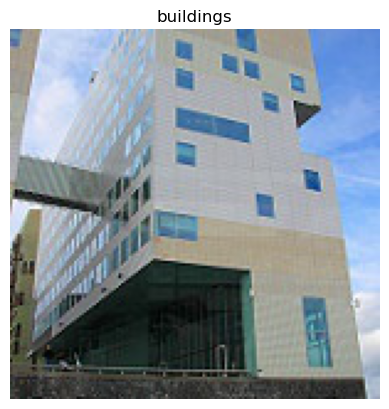

In [7]:
import random
img = view_random_image(target_dir=train_dir,target_class=random.choice(class_names))

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ig
train_datagen = ig(rescale=1/255.,
                  rotation_range=0.3,
                  width_shift_range=0.3,
                  height_shift_range=0.4,
                  zoom_range=0.2,
                  horizontal_flip=True)
test_datagen = ig(1/255.)
train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size = (224,224),
                                              batch_size = 32,
                                              class_mode = "categorical")
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size = (224,224),
                                            batch_size=32,
                                            class_mode = "categorical")

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D,Conv2D,Dense,Activation,Flatten


In [10]:
image_class_model = Sequential([
    Conv2D(10,3,input_shape=(224,224,3),activation="relu"),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Conv2D(10,3,activation="relu"),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(32,activation="relu"),
    Dense(6,activation="softmax")
    
])
image_class_model.compile(loss="categorical_crossentropy",optimizer = tf.keras.optimizers.legacy.Adam(),
                           metrics=["accuracy"])

2023-11-23 09:55:18.677895: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-23 09:55:18.677921: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-23 09:55:18.677929: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-23 09:55:18.678444: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-23 09:55:18.678708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
with tf.device('/CPU:0'):
    history = image_class_model.fit(train_data,
                               epochs=5,
                               steps_per_epoch=len(train_data),
                               validation_data=test_data,
                               validation_steps=len(test_data))

Epoch 1/5


2023-11-23 09:55:20.087855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 70/439 [===>..........................] - ETA: 5:12 - loss: 1.4572 - accuracy: 0.4067

KeyboardInterrupt: 

In [ ]:
def plot_loss_curves(history):
    loss=history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    plt.plot(epochs,loss,label="training_loss")
    plt.plot(epochs,val_loss,label="val_LOSS")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    #plot the accuracy
    plt.figure()
    plt.plot(epochs,accuracy,label="training_accuracy")
    plt.plot(epochs,val_accuracy,label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

In [ ]:
plot_loss_curves(history)

In [ ]:
image_class_model.save("6_class_image.h5")


In [12]:
load_image_model = tf.keras.models.load_model("6_class_image.h5")

In [13]:
def load_and_prep_image(filename,img_shape=224):
    
    img = tf.io.read_file(filename)
    
    img = tf.image.decode_image(img)
    img = tf.image.resize(img,size = [img_shape,img_shape])
   
    
    
    img = img/255.
    return img

In [14]:
def pred_and_plot(model,filename,class_names=class_names):
    img = load_and_prep_image(filename)
    pred = model.predict(tf.expand_dims(img,axis=0)) 
    if len(pred[0])>1:
        pred_class = class_names[tf.argmax(pred[0])]
    else:
        pred_class = class_names[int(tf.round(pred))]
    plt.imshow(img)
    plt.title(f"Prediction : {pred_class}")
    plt.axis(False)

2023-11-23 09:56:53.073574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 448ms/step


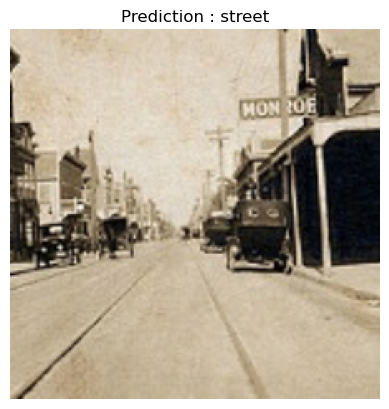

In [16]:
pred_and_plot(model=load_image_model,filename="archive-4/seg_pred/seg_pred/14.jpg",class_names=class_names)